# Specular Highlight Removal
### Matthew Barrett

Setup

In [1]:
# Setup
%matplotlib inline
import cv2
from PIL import Image
import numpy as np
from skimage.exposure import match_histograms
from IPython.display import display
import tkinter as tk
import time
from functools import wraps

root = tk.Tk()
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

# Taken from https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def measure_time(wrapped):
    @wraps(wrapped)
    def wrapper(*args,**kwds):
        t1=time.time()
        ret=wrapped(*args,**kwds)
        t2=time.time()
        print('@measure_time: {0} took {1} seconds'.format(wrapped.__name__,t2-t1))
        return ret
    return wrapper

def show(img):
    img = image_resize(img, width=int(screen_width/3))
    pil_img = Image.fromarray(img)
    display(pil_img)


## Methods

### Method 1: Simple Thresholding

1. Gaussian Blur
1. CLAHE Histogram Equaliziation
1. Thresholding (Binary, Adaptive, Otsu)
1. Morphological Close
1. Inpainting


In [2]:
# @measure_time
# def remove_glare(img_path = "SHIQ/train/00003_A.png", threshold = 220):
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     rgb = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_RGB2BGR)

#     assert img is not None, "File could not be read"

#     # BLUR
#     blur = cv2.GaussianBlur(img, (5,5), 0)

#     # HISTOGRAM EQUALIZATION
#     clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(16,16), )
#     clahe = clahe.apply(blur)

#     # THRESHOLDING
#     _, binary = cv2.threshold(clahe, threshold, 255, cv2.THRESH_BINARY)

#     adapt = cv2.adaptiveThreshold(clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

#     _, otsu = cv2.threshold(clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     # MORPHOLOGICAL CLOSE
#     kernel = np.ones((3,3), np.uint8)
#     binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
#     adapt = cv2.morphologyEx(adapt, cv2.MORPH_CLOSE, kernel)
#     otsu = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)

#     # INPAINT
#     result_binary = cv2.inpaint(rgb, binary, 3, cv2.INPAINT_TELEA)
#     result_adapt = cv2.inpaint(rgb, adapt, 3, cv2.INPAINT_TELEA)
#     result_otsu = cv2.inpaint(rgb, otsu, 3, cv2.INPAINT_TELEA)  

#     # DISPLAY RESULTS and STEPS
#     print("Glare Mask Threshold: ", threshold)
#     show(binary)
#     print("Adaptive Threshold Mask")
#     show(adapt)
#     print("Otsu Threshold Mask")
#     show(otsu)
#     print("Threshold Result")
#     show(result_binary)
#     print("Adaptive Result")
#     show(result_adapt)
#     print("Otsu Result")
#     show(result_otsu)

# #input_image_path = "SHIQ/train/00003_A.png"
# input_image_path = "frames/frame_0169.png"
# # input_image_path = "che.jpg"
# remove_glare(input_image_path)
def remove_glare(img):
    hh, ww = img.shape[:2]

    # threshold
    lower = (150,150,150)
    upper = (240,240,240)
    thresh = cv2.inRange(img, lower, upper)

    # apply morphology close and open to make mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))
    morph = cv2.morphologyEx(morph, cv2.MORPH_DILATE, kernel, iterations=1)

    # floodfill the outside with black
    black = np.zeros([hh + 2, ww + 2], np.uint8)
    mask = morph.copy()
    mask = cv2.floodFill(mask, black, (0,0), 0, 0, 0, flags=8)[1]
    # use mask with input to do inpainting
    result1 = cv2.inpaint(img, mask, 101, cv2.INPAINT_TELEA)
    result2 = cv2.inpaint(img, mask, 101, cv2.INPAINT_NS)
    return result1

img = cv2.imread("frames/frame_0169.png")
output = remove_glare(img)
show(output)



### Method 2: [Daisuke Miyazaki](http://www.info.hiroshima-cu.ac.jp/~miyazaki/profile/index.html)

#### [Specular-free画像](http://www.info.hiroshima-cu.ac.jp/~miyazaki/knowledge/tech0040.html)'s Calculations：


1. $\begin{pmatrix}
m_1 \\
m_2 \\
m_3 \end{pmatrix} =
\begin{pmatrix}
1 & -\frac{1}{2} & -\frac{1}{2} \\
0 & \frac{\sqrt{3}}{2} & -\frac{\sqrt{3}}{2} \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3}
\end{pmatrix} \begin{pmatrix}
r \\
g \\
b
\end{pmatrix}$

1. $\begin{pmatrix}
\hat{m_1} \\
\hat{m_2} \\
\hat{m_3} \end{pmatrix} = \begin{pmatrix}
m_1 \\
m_2 \\
a\sqrt{m_1^2 + m_2^2} \end{pmatrix}$

1. $\begin{pmatrix}
\hat{r} \\
\hat{g} \\
\hat{b} \end{pmatrix} = \begin{pmatrix}
\frac{2}{3} & 0 & 1 \\
-\frac{1}{3} & \frac{1}{\sqrt{3}} & 1 \\
-\frac{1}{3} & -\frac{1}{\sqrt{3}} & 1
\end{pmatrix} \begin{pmatrix}
\hat{m_1} \\
\hat{m_2} \\
\hat{m_3} \end{pmatrix}$

オリジナル


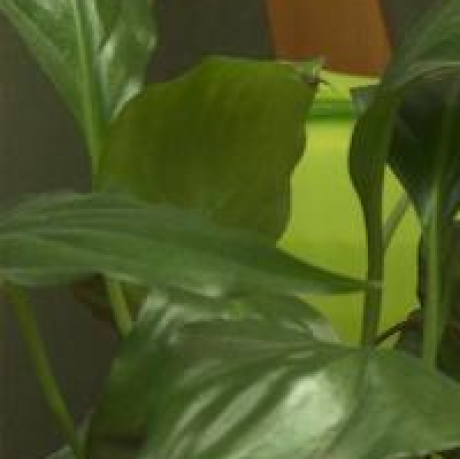

結果、a = 1.5


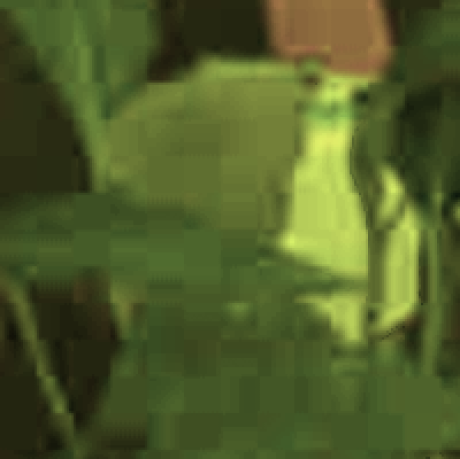

@measure_time: transform took 0.037131309509277344 seconds


In [24]:
@measure_time
def transform(img_path = "SHIQ/train/00003_A.png", a = 2):
    try:
        img = Image.open(img_path)
    except Exception as ex:
        print("An exception has occured: ", ex)
        return
    img = img.convert("RGB")
    pixels = np.array(img)

    transformation_matrixA = np.array([
        [1, -0.5, -0.5],
        [0, np.sqrt(3)/2, -np.sqrt(3)/2],
        [1/3, 1/3, 1/3]
    ])

    transformation_matrixB = np.array([
        [2/3, 0, 1],
        [-1/3, 1/np.sqrt(3), 1],
        [-1/3, -1/np.sqrt(3), 1]
    ])
    # APPLY TRANSFORMATION 1
    transformed_pixelsA = pixels @ transformation_matrixA.T

    m1 = transformed_pixelsA[:,:,0]
    m2 = transformed_pixelsA[:,:,1]
    m3 = transformed_pixelsA[:,:,2]

    # APPLY TRANSFORMATION 2
    mh1 = m1
    mh2 = m2
    mh3 = a * np.sqrt(m1**2 + m2**2)

    mh = np.stack((mh1, mh2, mh3), axis = -1)

    # APPLY TRANSFORMATION 3
    transformed_pixelsB = mh @ transformation_matrixB.T
    transformed_pixelsB = np.clip(transformed_pixelsB, 0, 255)
    transformed_pixelsB = transformed_pixelsB.astype(np.uint8)

    # DISPAY
    print("オリジナル")
    show(pixels)
    print("結果、a =", a)
    show(transformed_pixelsB)

input_image_path = "SHIQ/train/00003_A.png"
transform(input_image_path, 1.5)

### Method 3: Vítor S. Ramos et al.
#### [Single Image Highlight Removal for Real-Time Image Processing Pipelines](https://ieeexplore.ieee.org/document/8945327)

Using YCbCr



オリジナル


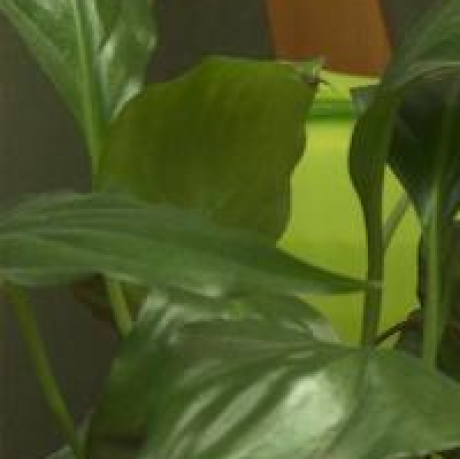

結果


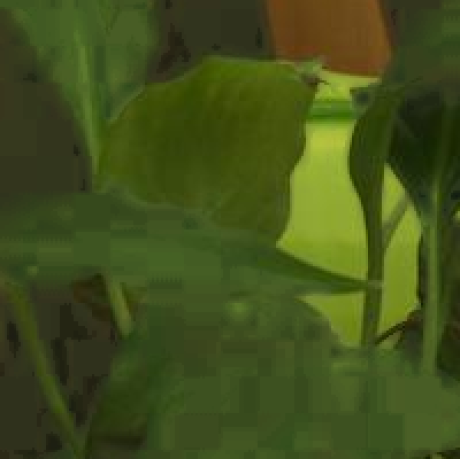

@measure_time: remove_specular took 0.15110230445861816 seconds


In [3]:
def rgb_to_ycbcr(image):
    # ITU-R BT.709 conversion
    transform_matrix = np.array([[0.2126, 0.7152, 0.0722],
                                  [-0.1146, -0.3854, 0.5],
                                  [0.5, -0.4542, -0.0458]])
    ycbcr = image @ transform_matrix.T
    return ycbcr

def ycbcr_to_rgb(ycbcr):
    # ITU-R BT.709 conversion
    transform_matrix = np.array([[1, 0, 1.5748],
                                 [1, -0.1873, -0.4681],
                                 [1, 1.8556, 0]])
    rgb = ycbcr @ transform_matrix.T
    return np.clip(rgb, 0, 255).astype(np.uint8)

@measure_time
def remove_specular(img_path = "SHIQ/train/00003_A.png", eta=0):
    with Image.open(img_path) as img:
        img = img.convert("RGB")
        img = np.array(img)

        # Calculate I_min
        I_min = np.min(img, axis=2)

        # Calculate psf
        min_rgb_stacked = np.stack([I_min] * 3, axis=2)
        psf = img - min_rgb_stacked

        # Convert psf from RGB to Y
        psf_Y = psf @ np.array([0.299, 0.587, 0.114])

        # Normalize psf_Y
        psf_Y = (psf_Y - psf_Y.min()) / (psf_Y.max() - psf_Y.min()) * 255
        psf_Y = psf_Y.astype(np.float64)

        # Convert img from RGB to YCbCr and extract each channel
        img_ycbcr = rgb_to_ycbcr(img)
        I_y, I_cb, I_cr = img_ycbcr[:, :, 0], img_ycbcr[:, :, 1], img_ycbcr[:, :, 2]

        # Calculate beta
        beta = I_min.mean()

        # Define U and apply mask to I_y
        U = I_min < beta * eta
        I_y[U] = 0

        # Match the histogram of psf_Y to I_y
        hm = match_histograms(psf_Y, I_y)

        # Take the minimum of I_y and hm
        I_y = np.minimum(I_y, hm)

        # Combine I_y, I_cb, I_cr back to YCbCr
        img_ycbcr = np.stack([I_y, I_cb, I_cr], axis=2)

        # Convert YCbCr back to RGB
        img_rgb = ycbcr_to_rgb(img_ycbcr)

        # Display the image
        print("オリジナル")
        show(img)
        print("結果")
        show(img_rgb)
        # cv2.imwrite("output.png", cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))

img_path = "SHIQ/train/00003_A.png"
eta = 0
remove_specular(img_path, eta)


In [29]:
import os
import shutil
from tqdm import tqdm

# 1. Extract frames from a video
def extract_frames(video_path, output_dir="frames"):
    # Clear the output directory if it exists
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    
    # Create the directory again after clearing it
    os.makedirs(output_dir, exist_ok=True)
    
    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    count = 0
    
    with tqdm(total=min(total_frames, 256), desc="Extracting Frames") as pbar:
        while count < 256:  # Limit to 256 frames
            success, image = vidcap.read()
            if not success:
                break
            
            cv2.imwrite(f"{output_dir}/frame_{count:04d}.png", image)  # Save frame as PNG
            count += 1
            pbar.update(1)  # Update the progress bar
    
    vidcap.release()
    print(f"Extracted {count} frames")

# 2. Remove specular highlights from an image
# Method 1: Otsu's Thresholding
# def remove_specular(img):
#     rgb = img.copy()
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

#     assert img is not None, "File could not be read"

#     # BLUR
#     blur = cv2.GaussianBlur(img, (5,5), 0)

#     # HISTOGRAM EQUALIZATION
#     clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(16,16), )
#     clahe = clahe.apply(blur)

#     _, otsu = cv2.threshold(clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     # MORPHOLOGICAL CLOSE
#     kernel = np.ones((5,5), np.uint8)

#     otsu = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)

#     result_otsu = cv2.inpaint(rgb, otsu, 3, cv2.INPAINT_TELEA)  
#     return result_otsu

# Method 2: Miyazaki's Method
# def remove_specular(img, a = 2):
#     pixels = img.copy()

#     transformation_matrixA = np.array([
#         [1, -0.5, -0.5],
#         [0, np.sqrt(3)/2, -np.sqrt(3)/2],
#         [1/3, 1/3, 1/3]
#     ])

#     transformation_matrixB = np.array([
#         [2/3, 0, 1],
#         [-1/3, 1/np.sqrt(3), 1],
#         [-1/3, -1/np.sqrt(3), 1]
#     ])
#     # APPLY TRANSFORMATION 1
#     transformed_pixelsA = pixels @ transformation_matrixA.T

#     m1 = transformed_pixelsA[:,:,0]
#     m2 = transformed_pixelsA[:,:,1]
#     m3 = transformed_pixelsA[:,:,2]

#     # APPLY TRANSFORMATION 2
#     mh1 = m1
#     mh2 = m2
#     mh3 = a * np.sqrt(m1**2 + m2**2)

#     mh = np.stack((mh1, mh2, mh3), axis = -1)

#     # APPLY TRANSFORMATION 3
#     transformed_pixelsB = mh @ transformation_matrixB.T
#     transformed_pixelsB = np.clip(transformed_pixelsB, 0, 255)
#     transformed_pixelsB = transformed_pixelsB.astype(np.uint8)

#     return transformed_pixelsB  

# Method 3: YCbCr Method
def remove_specular(img, eta=0):
    img = np.array(img)

    # Calculate I_min
    I_min = np.min(img, axis=2)

    # Calculate psf
    min_rgb_stacked = np.stack([I_min] * 3, axis=2)
    psf = img - min_rgb_stacked

    # Convert psf from RGB to Y
    psf_Y = psf @ np.array([0.299, 0.587, 0.114])

    # Normalize psf_Y
    psf_Y = (psf_Y - psf_Y.min()) / (psf_Y.max() - psf_Y.min()) * 255
    psf_Y = psf_Y.astype(np.float64)

    # Convert img from RGB to YCbCr and extract each channel
    img_ycbcr = rgb_to_ycbcr(img)
    I_y, I_cb, I_cr = img_ycbcr[:, :, 0], img_ycbcr[:, :, 1], img_ycbcr[:, :, 2]

    # Calculate beta
    beta = I_min.mean()

    # Define U and apply mask to I_y
    U = I_min < beta * eta
    I_y[U] = 0

    # Match the histogram of psf_Y to I_y
    hm = match_histograms(psf_Y, I_y)

    # Take the minimum of I_y and hm
    I_y = np.minimum(I_y, hm)

    # Combine I_y, I_cb, I_cr back to YCbCr
    img_ycbcr = np.stack([I_y, I_cb, I_cr], axis=2)

    # Convert YCbCr back to RGB
    img_rgb = ycbcr_to_rgb(img_ycbcr)

    return img_rgb

# 3. Process all frames and save results
def process_frames(input_dir="frames", output_dir="processed_frames"):
    # Clear the output directory if it exists
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    
    # Create the directory again after clearing it
    os.makedirs(output_dir, exist_ok=True)
    
    frame_files = sorted(os.listdir(input_dir))
    
    with tqdm(total=len(frame_files), desc="Processing Frames") as pbar:
        for frame_file in frame_files:
            frame_path = os.path.join(input_dir, frame_file)
            frame = cv2.imread(frame_path)

            if frame is not None:
                processed_frame = remove_specular(frame)
                cv2.imwrite(f"{output_dir}/{frame_file}", processed_frame)
                
            pbar.update(1)  # Update the progress bar

    print(f"Processed {len(frame_files)} frames")

# 4. Rebuild video from processed frames
def rebuild_video(output_video_path, frame_dir="processed_frames", original_video_path=None, fps=30):
    # Get the frame size from the original video if available, else assume a default frame size
    if original_video_path:
        vidcap = cv2.VideoCapture(original_video_path)
        frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        vidcap.release()
    else:
        first_frame = cv2.imread(os.path.join(frame_dir, sorted(os.listdir(frame_dir))[0]))
        frame_height, frame_width, _ = first_frame.shape

    frame_size = (frame_width, frame_height)

    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

    for frame_file in sorted(os.listdir(frame_dir)):
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        if frame is not None:
            out.write(frame)

    out.release()
    print(f"Rebuilt video saved to {output_video_path}")

# Main steps
video_path = 'ear.mp4'
output_video_path = 'ear_output_video_method_3.mp4'

# Step 1: Extract frames
extract_frames(video_path)

# Step 2: Process frames to remove specular highlights
process_frames()

# Step 3: Rebuild video from processed frames
rebuild_video(output_video_path, original_video_path=video_path)


Extracting Frames: 100%|██████████| 256/256 [00:04<00:00, 62.96it/s]


Extracted 256 frames


Processing Frames:  23%|██▎       | 58/256 [00:13<00:45,  4.35it/s]


KeyboardInterrupt: 

In [26]:
# Create video from ML model output
def rebuild_video(output_video_path, frame_dir="processed_frames", original_video_path=None, fps=30):
    # Get the frame size from the original video if available, else assume a default frame size
    if original_video_path:
        vidcap = cv2.VideoCapture(original_video_path)
        frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        vidcap.release()
    else:
        first_frame = cv2.imread(os.path.join(frame_dir, sorted(os.listdir(frame_dir))[0]))
        frame_height, frame_width, _ = first_frame.shape

    frame_size = (frame_width, frame_height)

    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

    for frame_file in sorted(os.listdir(frame_dir)):
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        # If there is a frame or the frame doesn't contain the words HFE, write it to the output video
        if frame is not None and "HFE" not in frame_file:
            out.write(frame)

    out.release()
    print(f"Rebuilt video saved to {output_video_path}")
rebuild_video('ear_output_video_ML.mp4', frame_dir='M2-Net/specular-removal/out')

Rebuilt video saved to cup_output_video_ML.mp4


In [ ]:
cd C:/Users/mbarr/OneDrive/Documents/Thesis/M2-Net/specular-removal
python infer.py --input_dir C:/Users/mbarr/OneDrive/Documents/Thesis/frames/ --output_dir ./out/ --infer_model ./savedmodel/Text_Face.mdl

In [ ]:
import os
import shutil
from tqdm import tqdm
import cv2
import numpy as np

# 1. Extract frames from a video
def extract_frames(video_path, output_dir="frames"):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    count = 0
    
    with tqdm(total=min(total_frames, 256), desc="Extracting Frames") as pbar:
        while count < 256:  # Limit to 256 frames
            success, image = vidcap.read()
            if not success:
                break
            cv2.imwrite(f"{output_dir}/frame_{count:04d}.png", image)  # Save frame as PNG
            count += 1
            pbar.update(1)
    
    vidcap.release()
    print(f"Extracted {count} frames")

# 2. Remove specular highlights from an image
# Method 1: Otsu's Thresholding
# def remove_specular(img):
#     rgb = img.copy()
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

#     assert img is not None, "File could not be read"

#     # BLUR
#     blur = cv2.GaussianBlur(img, (5,5), 0)

#     # HISTOGRAM EQUALIZATION
#     clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(16,16), )
#     clahe = clahe.apply(blur)

#     _, otsu = cv2.threshold(clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     # MORPHOLOGICAL CLOSE
#     kernel = np.ones((5,5), np.uint8)

#     otsu = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)

#     result_otsu = cv2.inpaint(rgb, otsu, 3, cv2.INPAINT_TELEA)  
#     return result_otsu

# Method 2: Miyazaki's Method
# def remove_specular(img, a = 2):
#     pixels = img.copy()

#     transformation_matrixA = np.array([
#         [1, -0.5, -0.5],
#         [0, np.sqrt(3)/2, -np.sqrt(3)/2],
#         [1/3, 1/3, 1/3]
#     ])

#     transformation_matrixB = np.array([
#         [2/3, 0, 1],
#         [-1/3, 1/np.sqrt(3), 1],
#         [-1/3, -1/np.sqrt(3), 1]
#     ])
#     # APPLY TRANSFORMATION 1
#     transformed_pixelsA = pixels @ transformation_matrixA.T

#     m1 = transformed_pixelsA[:,:,0]
#     m2 = transformed_pixelsA[:,:,1]
#     m3 = transformed_pixelsA[:,:,2]

#     # APPLY TRANSFORMATION 2
#     mh1 = m1
#     mh2 = m2
#     mh3 = a * np.sqrt(m1**2 + m2**2)

#     mh = np.stack((mh1, mh2, mh3), axis = -1)

#     # APPLY TRANSFORMATION 3
#     transformed_pixelsB = mh @ transformation_matrixB.T
#     transformed_pixelsB = np.clip(transformed_pixelsB, 0, 255)
#     transformed_pixelsB = transformed_pixelsB.astype(np.uint8)

#     return transformed_pixelsB  

# Method 3: YCbCr Method
# def remove_specular(img, eta=0):
#     img = np.array(img)

#     # Calculate I_min
#     I_min = np.min(img, axis=2)

#     # Calculate psf
#     min_rgb_stacked = np.stack([I_min] * 3, axis=2)
#     psf = img - min_rgb_stacked

#     # Convert psf from RGB to Y
#     psf_Y = psf @ np.array([0.299, 0.587, 0.114])

#     # Normalize psf_Y
#     psf_Y = (psf_Y - psf_Y.min()) / (psf_Y.max() - psf_Y.min()) * 255
#     psf_Y = psf_Y.astype(np.float64)

#     # Convert img from RGB to YCbCr and extract each channel
#     img_ycbcr = rgb_to_ycbcr(img)
#     I_y, I_cb, I_cr = img_ycbcr[:, :, 0], img_ycbcr[:, :, 1], img_ycbcr[:, :, 2]

#     # Calculate beta
#     beta = I_min.mean()

#     # Define U and apply mask to I_y
#     U = I_min < beta * eta
#     I_y[U] = 0

#     # Match the histogram of psf_Y to I_y
#     hm = match_histograms(psf_Y, I_y)

#     # Take the minimum of I_y and hm
#     I_y = np.minimum(I_y, hm)

#     # Combine I_y, I_cb, I_cr back to YCbCr
#     img_ycbcr = np.stack([I_y, I_cb, I_cr], axis=2)

#     # Convert YCbCr back to RGB
#     img_rgb = ycbcr_to_rgb(img_ycbcr)

#     return img_rgb

def remove_specular(img):
    img = img.copy()
    hh, ww = img.shape[:2]

    # threshold
    lower = (150,150,150)
    upper = (240,240,240)
    thresh = cv2.inRange(img, lower, upper)

    # apply morphology close and open to make mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))
    morph = cv2.morphologyEx(morph, cv2.MORPH_DILATE, kernel, iterations=1)

    # floodfill the outside with black
    black = np.zeros([hh + 2, ww + 2], np.uint8)
    mask = morph.copy()
    mask = cv2.floodFill(mask, black, (0,0), 0, 0, 0, flags=8)[1]

    # use mask with input to do inpainting
    result1 = cv2.inpaint(img, mask, 101, cv2.INPAINT_TELEA)
    return result1

# 3. Process all frames and save results
def process_frames(input_dir="frames", output_dir="processed_frames"):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    frame_files = sorted(os.listdir(input_dir))
    with tqdm(total=len(frame_files), desc="Processing Frames") as pbar:
        for frame_file in frame_files:
            frame_path = os.path.join(input_dir, frame_file)
            frame = cv2.imread(frame_path)
            if frame is not None:
                processed_frame = remove_specular(frame)  # Apply your specular highlight removal
                cv2.imwrite(f"{output_dir}/{frame_file}", processed_frame)
            pbar.update(1)

    print(f"Processed {len(frame_files)} frames")

# 4. Rebuild side-by-side video with text labels
def rebuild_side_by_side_video(output_video_path, original_frame_dir="frames", processed_frame_dir="processed_frames", fps=30):
    original_frames = sorted(os.listdir(original_frame_dir))
    processed_frames = sorted(os.listdir(processed_frame_dir))
    
    first_frame = cv2.imread(os.path.join(original_frame_dir, original_frames[0]))
    height, width, _ = first_frame.shape
    combined_frame_size = (width * 2, height)  # Twice the width for side-by-side display

    # Initialize video writer
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, combined_frame_size)
    
    for orig_file, proc_file in zip(original_frames, processed_frames):
        orig_frame = cv2.imread(os.path.join(original_frame_dir, orig_file))
        proc_frame = cv2.imread(os.path.join(processed_frame_dir, proc_file))

        # Overlay text on each frame
        cv2.putText(orig_frame, "ORIGINAL", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(proc_frame, "PROCESSED", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Concatenate frames side by side
        combined_frame = np.hstack((orig_frame, proc_frame))
        
        # Write combined frame to video
        out.write(combined_frame)

    out.release()
    print(f"Side-by-side video saved to {output_video_path}")

# Main steps
video_path = 'ear.mp4'
output_video_path = 'ear_output_side_by_side.mp4'

# Step 1: Extract frames
extract_frames(video_path)

# Step 2: Process frames to remove specular highlights
process_frames()

# Step 3: Rebuild side-by-side video with original and processed frames
rebuild_side_by_side_video(output_video_path)


Extracting Frames: 100%|██████████| 256/256 [00:04<00:00, 58.48it/s]


Extracted 256 frames


Processing Frames:   0%|          | 0/256 [00:00<?, ?it/s]